# A more complex example for modeling drug-protein interactions with asymmetric RAF kinase dimerization and two RAF inhibitors

Here, we propose a more complex example of modeling RAF kinases and RAF inhibitors by reproducing a model of asymmetric RAF kinase dimerization and combination of two RAF inhibitors. This model was originally developed in *Kholodenko BN (2015) Drug Resistance Resulting from Kinase Dimerization Is Rationalized by Thermodynamic Factors Describing Allosteric Inhibitor Effects. Cell Rep 12: 1939–1949*. In the paper, the model is shown in *Figure 3* and the corresponding rate derivations are in *Reaction List S3*. While in the original work the cooperative thermodynamic reaction rates were derived manually, here we use energy PySB (via energy BNG) to recreate the same reaction network structure.

First, we define the model:

In [1]:
from pysb import Model, Monomer, Parameter, Expression,  Rule, Observable, Initial, Annotation, EnergyPattern, ANY
from pysb.bng import generate_equations
from pysb.export import export
from pysb.core import as_complex_pattern, ComplexPattern
from sympy import exp, log

Model();
model.name='complex_example_asym_RAF_two_RAFi';

#define RAF kinase with a binding site for RAF (r) and a drug (i) that can be into two configurations when dimerized (R1,R2)
Monomer('R', ['r', 'i', 'state'], {'state':['none', 'R1', 'R2']});   
#define first RAF inhibitor with binding site for RAF 
Monomer('I1',['r']);   
#define second RAF inhibitor with binding site for RAF 
Monomer('I2',['r']);   

#define the initial conditions for R and I1,I2
Parameter('R_0',0.01);  # uM
Parameter('I1_0',0.0);  # uM
Parameter('I2_0',0.0);  # uM
Initial(R(r=None, i=None, state='none'), R_0);
Initial(I1(r=None), I1_0);
Initial(I2(r=None), I2_0);

#define kinetic parameters and rules for independent binding
#RAF dimerization
#define dissociation constant (kD), forward rate (kf) and distributionr rate (phi) for RAF dimerization
Parameter('kr_1',10);  #/s
Parameter('kf_1',1.0);  #/s/uM
Expression('Kd_1', kr_1 / kf_1);
Parameter('phi_1',1.0); #unitless 
#convert kinetic parameters into energies for RAF dimerization
Expression('Gf_1', log(kr_1/kf_1)); #unitless 
Expression('Ea0_1',-phi_1*log(kr_1/kf_1)-log(kf_1)); #unitless 
# define energy in bond between R and R
EnergyPattern('ep_1',R(r=1)%R(r=1),Gf_1);
#define RAF dimerization reaction with asymmetry of configurations R1 and R2
Rule('R1', R(r=None, state='none')+R(r=None, state='none') | R(r=1, state='R1')%R(r=1, state='R2') , phi_1, Ea0_1, energy=True);

#I1 binding to RAF
#define dissociation constant (kD), forward rate (kf) and distributionr rate (phi) for drug binding to RAF
Parameter('kr_2a',0.1);  #/s
Parameter('kf_2a',1.0);  #/s/uM
Expression('Kd_2a', kr_2a / kf_2a);
Parameter('phi_2a',1.0); #unitless
#convert kinetic parameters into energies for drug binding to RAF
Expression('Gf_2a', log(kr_2a/kf_2a)); #unitless 
Expression('Ea0_2a',-phi_2a*log(kr_2a/kf_2a)-log(kf_2a)); #unitless 
# define energy in bond between R and I
EnergyPattern('ep_2a',R(i=1)%I1(r=1),Gf_2a);
#define drug binding to RAF reaction
Rule('R2a', R(i=None)+I1(r=None) | R(i=1)%I1(r=1) , phi_2a, Ea0_2a, energy=True);

#I2 binding to RAF
#define dissociation constant (kD), forward rate (kf) and distributionr rate (phi) for drug binding to RAF
Parameter('kr_2b',0.1);  #/s
Parameter('kf_2b',1.0);  #/s/uM
Expression('Kd_2b', kr_2b / kf_2b);
Parameter('phi_2b',1.0); #unitless
#convert kinetic parameters into energies for drug binding to RAF
Expression('Gf_2b', log(kr_2b/kf_2b)); #unitless 
Expression('Ea0_2b',-phi_2b*log(kr_2b/kf_2b)-log(kf_2b)); #unitless 
# define energy in bond between R and I
EnergyPattern('ep_3',R(i=1)%I2(r=1),Gf_2b);
#define drug binding to RAF reaction
Rule('R2b', R(i=None)+I2(r=None) | R(i=1)%I2(r=1) , phi_2b, Ea0_2b, energy=True);

Next, we define the thermodynamic parameters and impose energy patterns to model cooperativity in drug-protein interactions.
The thermodynamic parameters quantify the following: 
* *f_a*: The Kd ratio of I1 binding to the free monomer R versus to the promoter R1 in the R1-R2 dimers (yielding R1I1-R2)
* *f_b*: The Kd ratio of I2 binding to the free monomer R versus to the promoter R1 in the R1-R2 dimers (yielding R1I2-R2)
* *g_1a*: The Kd ratio of I1 binding to the protomer R1 versus the promoter R2 in the R1-R2 dimers (yielding R1-R2I1)
* *g_1b*: The Kd ratio of I2 binding to the protomer R1 versus to the promoter R2 in the R1-R2 dimers (yielding R1-R2I2)
* *g_2a*: The Kd ratio of I1 binding to the free monomer R versus to the protomer R1 in the R1-R2I1 dimers (yielding R1I1R2I1)
* *g_2b*: The Kd ratio of I2 binding to the free monomer R versus to the protomer R1 in the R1-R2I2 dimers (yielding R1I2R2I1)
* *g_3a*: The Kd ratio of I1 binding to a free monomer R versus to the promoter R1 in the R1-R2I2 dimer (yielding R1I1-R2I2) 
* *g_3b*: The Kd ratio of I2 binding to a free monomer R versus to the promoter R1 in the R1-R2I1 dimer (yielding R1I1-R2I1) 

In [2]:
#define thermodynamic factors
Parameter('f_a',1.0);  #unitless 
Parameter('f_b',1.0);  #unitless 
Parameter('g_1a',1.0);  #unitless
Parameter('g_1b',1.0);  #unitless
Parameter('g_2a',1.0);  #unitless
Parameter('g_2b',1.0);  #unitless
Parameter('g_3a',1.0);  #unitless
Parameter('g_3b',1.0);  #unitless

#convert thermodynamic factors in energies 
Expression('Gf_fa',log(f_a)); #unitless 
Expression('Gf_fb',log(f_b)); #unitless 
Expression('Gf_g1a',log(g_1a)); #unitless 
Expression('Gf_g1b',log(g_1b)); #unitless 
Expression('Gf_g2a',log(g_2a)); #unitless 
Expression('Gf_g2b',log(g_2b)); #unitless 
Expression('Gf_g3a',log(g_3a)); #unitless 
Expression('Gf_g3b',log(g_3b)); #unitless 

#define energy patterns for fa
EnergyPattern('ep_fa_R2R1I1',R(r=1,state='R2')%R(r=1,i=2,state='R1')%I1(r=2), Gf_fa);
#define energy patterns for fb
EnergyPattern('ep_fb_R2R1I2',R(r=1,state='R2')%R(r=1,i=2,state='R1')%I2(r=2), Gf_fb);
#define energy patterns for g1a
Expression('Gf_g1a_fa', Gf_g1a + Gf_fa);
EnergyPattern('ep_g1a_R1R2I1',R(r=1,state='R1')%R(r=1,i=2,state='R2')%I1(r=2), Gf_g1a_fa);
#define energy patterns for g1b
Expression('Gf_g1b_fb', Gf_g1b + Gf_fb);
EnergyPattern('ep_g1b_R1R2I2',R(r=1,state='R1')%R(r=1,i=2,state='R2')%I2(r=2), Gf_g1b_fb);
#define energy pattern for g2a
Expression('Gf_g2a_fa', Gf_g2a - Gf_fa);
EnergyPattern('ep_g2a_I1R1R2I1',I1(r=3)%R(r=1,i=3,state='R1')%R(r=1,i=2,state='R2')%I1(r=2), Gf_g2a_fa);
#define energy pattern for g2b
Expression('Gf_g2b_fb', Gf_g2b - Gf_fb);
EnergyPattern('ep_g2b_I2R1R2I2',I2(r=3)%R(r=1,i=3,state='R1')%R(r=1,i=2,state='R2')%I2(r=2), Gf_g2b_fb);
#define energy pattern for g3a
Expression('Gf_g3a_fa', Gf_g3a - Gf_fa);
EnergyPattern('ep_g3a_I1R1R2I2',I2(r=3)%R(r=1,i=3,state='R2')%R(r=1,i=2,state='R1')%I1(r=2), Gf_g3a_fa);
#define energy pattern for g3b
Expression('Gf_g3b_fb', Gf_g3b - Gf_fb);
EnergyPattern('ep_g3b_I2R1R2I1',I1(r=3)%R(r=1,i=3,state='R2')%R(r=1,i=2,state='R1')%I2(r=2), Gf_g3b_fb);

#define the observable for total kinase activity (proportional to the weighted sum of the concentrations of
#inhibitor free monomers and dimers and partially inhibited dimers: we assume lamba 10-15, p1=p2=0.5, see Section S2.5 
#of the original paper)
Parameter('kcat',1.0);  
Parameter('plambda',10.0);  
Parameter('p1', 0.5);  
Parameter('p2', 0.5);  
Observable('R_obs', R(i=None, r=None));
Observable('RR_obs', R(i=None, r=1)%R(i=None, r=1));
Observable('R1R2I_obs', R(i=ANY, r=1, state='R1')%R(i=None, r=1, state='R2'));
Observable('R2R1I_obs', R(i=ANY, r=1, state='R2')%R(i=None, r=1, state='R1'));
Observable('IRRI_obs', R(i=ANY, r=1,)%R(i=ANY, r=1, state='R1'));
Expression('R_active', kcat * (R_obs + plambda * ( RR_obs + p1 * (R1R2I_obs) + p2 * (R2R1I_obs) ) ));

We generate the kinetic model:

In [3]:
from util_display import display_model_info

# generate the model equations
generate_equations(model)

#display model informations
display_model_info(model)

#save the generated model in PySB and BNG format
generated_model_code = export(model, 'pysb_flat')
with open(model.name+'.py', 'wt') as f:
    f.write(generated_model_code);

generated_model_code = export(model, 'bngl')
with open(model.name+'.bngl', 'wt') as f:
    f.write(generated_model_code);

Model information
Species: 14
Parameters: 27
Expressions: 24
Observables: 5
Total Rules: 3
Energy Rules: 3
Non-energy Rules: 0
Energy Patterns: 11
Reactions: 46


We inspect the species and reaction rates generated by the energy-based model formulation: 

In [4]:
from util_display import format_species_reactions, display_table
import pandas as pd
# Prevent pandas from truncating long LaTeX expressions when rendering.
pd.options.display.max_colwidth=None

#obtain dataframe with math latex expression visualization for species and reactions
(speciesdisp, reactionsdisp)=format_species_reactions(model);
#display species with the right style
display_table(speciesdisp, caption='SPECIES');

#display reactions in the same order as Reaction List S3 in original publication 
reaction_order=[0,1,2,11,13, 12, 14, 5, 8, 3, 4, 17, 22, 15, 20, 6, 10, 7, 21, 16, 9, 18, 19];
display_table(reactionsdisp.iloc[reaction_order], caption='REACTIONS');

ID,Pattern
\[s_{0}\],"R(r=None, i=None, state='none')"
\[s_{1}\],I1(r=None)
\[s_{2}\],I2(r=None)
\[s_{3}\],"R(r=1, i=None, state='R1') % R(r=1, i=None, state='R2')"
\[s_{4}\],"I1(r=1) % R(r=None, i=1, state='none')"
\[s_{5}\],"I2(r=1) % R(r=None, i=1, state='none')"
\[s_{6}\],"I1(r=1) % R(r=2, i=1, state='R2') % R(r=2, i=None, state='R1')"
\[s_{7}\],"I2(r=1) % R(r=2, i=1, state='R2') % R(r=2, i=None, state='R1')"
\[s_{8}\],"I1(r=1) % R(r=2, i=1, state='R1') % R(r=2, i=None, state='R2')"
\[s_{9}\],"I1(r=1) % I1(r=2) % R(r=3, i=1, state='R1') % R(r=3, i=2, state='R2')"


ID,Base rule,Reaction,Forward rate ($k$ ),Backward rate ($kr$ ),Dissociation constant ($K_d$ )
\[R_{0}\],R1,$s_{0}$ + $s_{0}$ ⇄ $s_{3}$,\[k_{1}\],\[kr_{1}\],\[\frac{kr_{1}}{k_{1}}\]
\[R_{1}\],R2a,$s_{0}$ + $s_{1}$ ⇄ $s_{4}$,\[k_{2a}\],\[kr_{2a}\],\[\frac{kr_{2a}}{k_{2a}}\]
\[R_{2}\],R2b,$s_{0}$ + $s_{2}$ ⇄ $s_{5}$,\[k_{2b}\],\[kr_{2b}\],\[\frac{kr_{2b}}{k_{2b}}\]
\[R_{11}\],R2a,$s_{1}$ + $s_{3}$ ⇄ $s_{8}$,\[f_{a}^{- \phi_{2a}} \cdot k_{2a}\],\[f_{a}^{1 - \phi_{2a}} \cdot kr_{2a}\],\[\frac{f_{a} \cdot kr_{2a}}{k_{2a}}\]
\[R_{13}\],R2b,$s_{2}$ + $s_{3}$ ⇄ $s_{11}$,\[f_{b}^{- \phi_{2b}} \cdot k_{2b}\],\[f_{b}^{1 - \phi_{2b}} \cdot kr_{2b}\],\[\frac{f_{b} \cdot kr_{2b}}{k_{2b}}\]
\[R_{12}\],R2a,$s_{1}$ + $s_{3}$ ⇄ $s_{6}$,\[k_{2a} \cdot \left(\frac{1}{f_{a} \cdot g_{1a}}\right)^{\phi_{2a}}\],\[kr_{2a} \cdot \left(f_{a} \cdot g_{1a}\right)^{1 - \phi_{2a}}\],\[\frac{f_{a} \cdot g_{1a} \cdot kr_{2a}}{k_{2a}}\]
\[R_{14}\],R2b,$s_{2}$ + $s_{3}$ ⇄ $s_{7}$,\[k_{2b} \cdot \left(\frac{1}{f_{b} \cdot g_{1b}}\right)^{\phi_{2b}}\],\[kr_{2b} \cdot \left(f_{b} \cdot g_{1b}\right)^{1 - \phi_{2b}}\],\[\frac{f_{b} \cdot g_{1b} \cdot kr_{2b}}{k_{2b}}\]
\[R_{5}\],R1,$s_{0}$ + $s_{4}$ ⇄ $s_{8}$,\[f_{a}^{- \phi_{1}} \cdot k_{1}\],\[f_{a}^{1 - \phi_{1}} \cdot kr_{1}\],\[\frac{f_{a} \cdot kr_{1}}{k_{1}}\]
\[R_{8}\],R1,$s_{0}$ + $s_{5}$ ⇄ $s_{11}$,\[f_{b}^{- \phi_{1}} \cdot k_{1}\],\[f_{b}^{1 - \phi_{1}} \cdot kr_{1}\],\[\frac{f_{b} \cdot kr_{1}}{k_{1}}\]
\[R_{3}\],R1,$s_{0}$ + $s_{4}$ ⇄ $s_{6}$,\[k_{1} \cdot \left(\frac{1}{f_{a} \cdot g_{1a}}\right)^{\phi_{1}}\],\[kr_{1} \cdot \left(f_{a} \cdot g_{1a}\right)^{1 - \phi_{1}}\],\[\frac{f_{a} \cdot g_{1a} \cdot kr_{1}}{k_{1}}\]


Having generated the model, we can now study the efficacy of RAF inhibitors with different thermodynamic properties using model simulations. First, we set up parameters to reproduce Figures 3B,C in the original paper which shows the synergy between I1 and I2 with under certain conditions of cooperativity. 

In [5]:
from pysb.simulator import ScipyOdeSimulator
import numpy as np

#set initial conditions
model.parameters['R_0'].value=1.0;
model.parameters['I1_0'].value=0.0;
model.parameters['I2_0'].value=0.0;

#set kinetic parameters
model.parameters['kf_1'].value=1.0;  #Kd_1= 10
model.parameters['kr_1'].value=10.0;
model.parameters['kf_2a'].value=1.0; #Kd_2a= 1 
model.parameters['kr_2a'].value=1.0; 
model.parameters['kf_2b'].value=1.0; #Kd_2b= 1
model.parameters['kr_2b'].value=1.0;

#set thermodynamic parameters
model.parameters['f_a'].value=0.01; #I1 binds R1 in R1R2 dimers better than binding R
model.parameters['f_b'].value=0.005; #I2 binds R1 in R1R2 dimers better than binding R
model.parameters['g_1a'].value=2; #I1 does not bind I1R1R2 as well
model.parameters['g_1b'].value=5; #I2 does not bind I2R1R2 as well
model.parameters['g_2a'].value=10; #I1 does not bind R1R2I1 as well
model.parameters['g_2b'].value=20; #I2 does not bind R1R2I2 as well
model.parameters['g_3a'].value=0.01; #I1 binds R1R2I2 dimers better than binding R
model.parameters['g_3b'].value=10; #I2 does not bind R1R2I1 dimers better than binding R

#set the dilution range for the RAF inhibitors
I1_doses=np.concatenate((np.array([0]), np.logspace(-4, 1, 21, base=10.0)));
I2_doses=np.concatenate((np.array([0]), np.logspace(-4, 1, 21, base=10.0)));

#set up the ODE simulator for the model
sim = ScipyOdeSimulator(model);

Next, we simulate the response of the model for each combination of the selected RAF inhibitor concentrations: 

In [6]:
from tqdm.notebook import tqdm, trange
from util_simulation import equilibrate

#define observables and expression to extract
ext_species=['R_active', 'R_obs', 'RR_obs', 'R1R2I_obs', 'R2R1I_obs', 'IRRI_obs'];
ext_species_names=['RAF active', 'RAF_wt', 'R', 'RR', 'R1R2I', 'R2R1I', 'IRRI'];

doses = pd.merge(
    pd.Series(I1_doses, name="I1_0"), pd.Series(I2_doses, name="I2_0"), how="cross"
)
ss_v = pd.DataFrame(
    index=pd.MultiIndex.from_frame(doses), columns=ext_species, dtype=float
)

#for each drug dose combination
for i, r in tqdm(doses.iterrows(), desc="Simulation progress", total=len(doses)):
    #simulate the model to steady state
    res = equilibrate(sim, param_values=r.to_dict())
    #extract end of simulation for each selected species
    ss_v.loc[tuple(r)] = res.dataframe[ext_species].iloc[-1]

Simulation progress:   0%|          | 0/484 [00:00<?, ?it/s]

We plot the results as dilution dose response for I1, I2 and I2 with I1 at the fixed dose of I1_IC50 (Fig 3B):


<IPython.core.display.Javascript object>


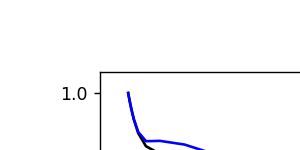

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

#plot Figure 3B
R_tot = ss_v.loc[(0, 0), "R_active"]
I1_IC50 = model.parameters['kr_2a'].value / model.parameters['kf_2a'].value
I2_IC50 = model.parameters['kr_2b'].value / model.parameters['kf_2b'].value
#for I1 only
I1_response = ss_v.xs(0.0, level="I2_0")["R_active"]
plt.plot(I1_response.index / I1_IC50, I1_response / R_tot, "k")
#for I2 only
I2_response = ss_v.xs(0.0, level="I1_0")["R_active"]
plt.plot(I2_response.index / I2_IC50, I2_response / R_tot, "b")
#for I2 at fixed I1 dose
I2_I1IC50_response = ss_v.xs(I1_IC50, level="I1_0")["R_active"]
plt.plot(I2_I1IC50_response.index / I2_IC50, I2_I1IC50_response / R_tot, "r");  
plt.xlabel('Inhibitor dose / IC50');
plt.ylabel('Normalized Total Activity');
#plt.xscale("log")

The plot above shows synergy of two drugs that used as single agents do not inhibit RAF signaling but when taken as a combination with a fixed dose of I1 are able to block it. To fully quantify synergy, we show the isobologram analysis of I1 and I2 drug-dose combinations (Fig 3C) and also calculate the degree of synergy according to Bliss independence:

<IPython.core.display.Javascript object>


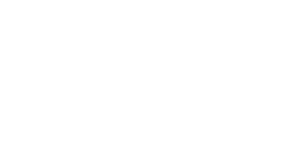

In [8]:
#import synergy package 
from synergy.combination import Bliss

#prepare data for synergy package
E=ss_v['R_active'].to_numpy()/R_tot;
E_matrix=ss_v["R_active"].unstack("I2_0").to_numpy()/R_tot;
E_matrix=np.rot90(E_matrix);
D1=ss_v.index.get_level_values(0).to_numpy();
D2=ss_v.index.get_level_values(1).to_numpy();
#create the Bliss and Loewe models
bliss = Bliss()
bliss.fit(D1, D2, E);

#plot Bliss analysis
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.title.set_text('Data')
im=ax.imshow(E_matrix, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax = fig.add_subplot(1,3,2)
ax.title.set_text('Bliss null model')
E_mat_bliss_ref=np.rot90(bliss.reference.reshape(len(I1_doses),len(I2_doses)));
im=ax.imshow(E_mat_bliss_ref, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax = fig.add_subplot(1,3,3)
ax.title.set_text('Bliss excess')
E_mat_bliss_syn=np.rot90(bliss.synergy.reshape(len(I1_doses),len(I2_doses)));
im=ax.imshow(E_mat_bliss_syn, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

Next, we simulate RAF inhibitors with different cooperativity properties to study how those influce the synergy among drugs (Figure S3 C-F in the original paper): 